In [15]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt

## Positional Embedding

They use increasing frequency of sine and cosine functions to encode each coordinate value in a higher dimensional vector.

TODO show 2D toy case how this helps

In [67]:
def get_positional_embedding_slow(coord_value, L):
    positional_embedding = torch.zeros(L*2)
    for i in range(L):
        positional_embedding[2*i] = math.sin(2**i * math.pi * coord_value)
        positional_embedding[2*i+1] = math.cos(2**i * math.pi * coord_value)
    return positional_embedding

def positional_embedding_vectorized(i, coord_value):
    return math.sin(2**i * math.pi * coord_value), math.cos(2**i * math.pi * coord_value)

def get_positional_embedding(coord, L):
    frequencies = np.arange(0,L)
    vec_pos_func = np.vectorize(positional_embedding_vectorized)
    return torch.stack([torch.Tensor(numpy_array) for numpy_array in vec_pos_func(frequencies, coord)], dim=-1).reshape(-1)


In [68]:
print(get_positional_embedding(1, 10))
print(get_positional_embedding(2, 10))

tensor([ 1.2246e-16, -1.0000e+00, -2.4493e-16,  1.0000e+00, -4.8986e-16,
         1.0000e+00, -9.7972e-16,  1.0000e+00, -1.9594e-15,  1.0000e+00,
        -3.9189e-15,  1.0000e+00, -7.8377e-15,  1.0000e+00, -1.5675e-14,
         1.0000e+00, -3.1351e-14,  1.0000e+00, -6.2702e-14,  1.0000e+00])
tensor([-2.4493e-16,  1.0000e+00, -4.8986e-16,  1.0000e+00, -9.7972e-16,
         1.0000e+00, -1.9594e-15,  1.0000e+00, -3.9189e-15,  1.0000e+00,
        -7.8377e-15,  1.0000e+00, -1.5675e-14,  1.0000e+00, -3.1351e-14,
         1.0000e+00, -6.2702e-14,  1.0000e+00, -1.2540e-13,  1.0000e+00])


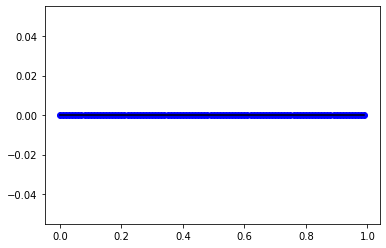

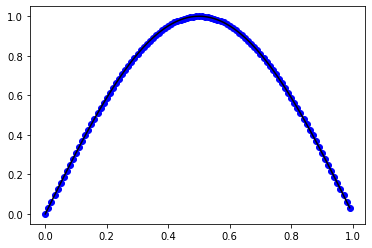

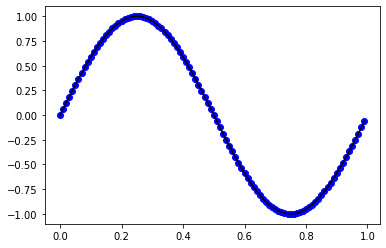

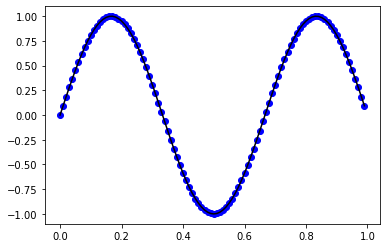

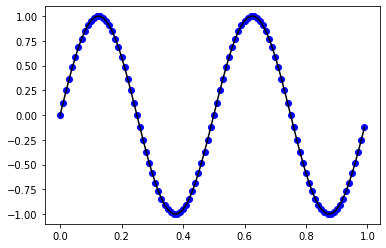

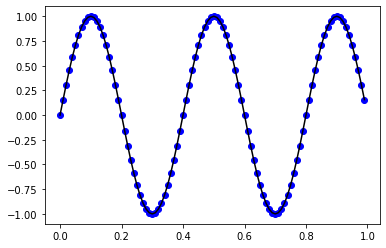

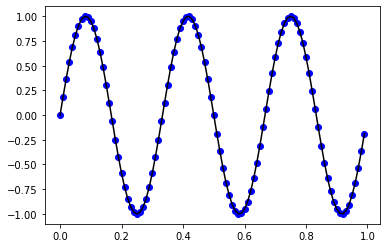

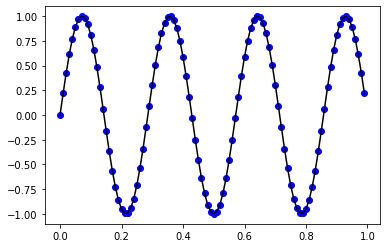

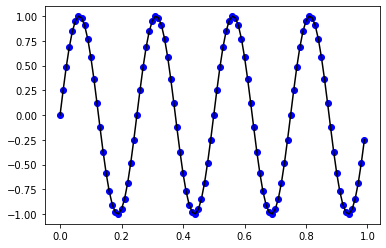

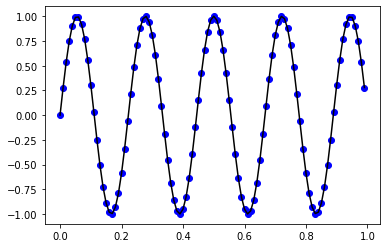

In [51]:
def sine_function(d,freq):
    return math.sin(freq*math.pi*d)
vecfunc = np.vectorize(sine_function)
for i in range(10):
    d = np.arange(0.0, 1.0, 0.01)
    T = vecfunc(d, i)
    plt.plot (d, T, 'bo', d, T, 'k')
    plt.show()

# Network

Each network takes in a x,y,z coordinate and a 3D Cartesian unit vector representing the direction

![Network Architecture from Paper](https://i.imgur.com/aTsZfWi.png)

In [97]:
import torch.nn as nn

class MLPModule(nn.Module):
    def __init__(self, feature_size=256):
        super(MLPModule, self).__init__()
        self.layer1 = self.make_mlp(4, 60, feature_size)
        self.layer2 = self.make_mlp(4, feature_size+60, feature_size)
        self.layer3 = nn.Sequential(self.make_mlp(1, feature_size+24, feature_size), 
                                    self.make_mlp(1, feature_size, feature_size//2))
        self.classify_rgb = nn.Linear(feature_size//2, 3)
        self.classify_density = nn.Linear(feature_size, 1)
        
    def make_mlp(self, num_layers, in_feature_size, out_feature_size):
        def nonlinear_layer(in_feature, out_feature):
            return nn.Sequential(nn.Linear(in_feature, out_feature), nn.ReLU())
        
        layers = [nonlinear_layer(in_feature_size, out_feature_size)]
        for i in range(1,num_layers):
            layers.append(nonlinear_layer(out_feature_size, out_feature_size))
        return nn.Sequential(*layers)
    
    def forward(self, x, d):
        x = torch.cat([get_positional_embedding(coord, L=10) for coord in x])
        d = torch.cat([get_positional_embedding(coord, L=4) for coord in d])
        
        out = self.layer1(x)
        x = self.layer2(torch.cat((x,out)))
        density = self.classify_density(x)
        
        x = self.layer3(torch.cat((x,d)))
        rgb = self.classify_rgb(x)
        
        return rgb, density

In [98]:
model = MLPModule(256)

In [99]:
model([1,2,3], [0.7,0.2,0.1])

(tensor([ 0.0214, -0.0716, -0.0504], grad_fn=<AddBackward0>),
 tensor([0.0002], grad_fn=<AddBackward0>))